## Лабораторая №1. Градиентный спуск и его модификации
   - Выбрать [тестовые функции оптимизации](https://ru.wikipedia.org/wiki/Тестовые_функции_для_оптимизации) (2 шт)
   - Запрограммировать собственную реализацию классического градиентного спуска
   - Запрограммировать пайлайн тестирования алгоритма оптимизации
     - Визуализации функции и точки оптимума
     - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
     - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
   - Запрограммировать метод вычисления градиента
     - Передача функции градиента от пользователя
     - Символьное вычисление градиента (например с помощью [sympy](https://www.sympy.org/en/index.html)) (на доп балл)
     - Численная аппроксимация градиента (на доп балл)
   - Запрограммировать одну моментную модификацию и протестировать ее
   - Запрограммировать одну адаптивную модификацию и протестировать ее
   - Запрограммировать метод эволюции темпа обучения и/или метод выбора начального приближения и протестировать их

## Реализация:
Тестовые функции для проверки алгоритмов:

*   Функция Розенброка для двух переменных: $$f(x,y) = (1-x)^2 + 100 (y-x^2)^2$$
Имеет глобальный минимум в точке $ (x,y) = (1, 1)$, где $ f(x,y) = 0 $.
*   Функция Била: $$ f(x,y)= (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2 $$
Имеет глобальный минимум в точке $ (x,y) = (3, 0.5)$, где $ f(x,y) = 0 $.




Определяем функции:

In [487]:
import sympy as sp

x, y = sp.symbols('x y')
rosenbrock = (1-x)**2 + 100 * (y-x**2)**2
beale = (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

Построим выбранные функции:

In [488]:
import numpy as np
from matplotlib import pyplot as plt


def show_function(x_vals, y_vals, func, found_optimum, title, azim=60, func_optimums = None):
    X, Y = np.meshgrid(x_vals, y_vals)
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection='3d'))
    f_num = sp.lambdify((x, y), func, "numpy")
    ax.plot_surface(X, Y, f_num(X, Y), cmap='jet', alpha=0.5)
    if func_optimums is not None:
        for index, optimum in enumerate(func_optimums):
            z = f_num(*optimum)
            ax.scatter3D(optimum[0], optimum[1], z, color='orange', s=100,
                label=f'Найденная точка оптимума {index + 1}: {round(optimum[0], 3), round(optimum[1], 3)}, f={round(z, 7)}')
    z = f_num(*found_optimum)
    ax.scatter3D(*found_optimum, z, color='green', s=100,
        label=f'Исходная точка оптимума: {round(found_optimum[0], 3), round(found_optimum[1], 3)}, f={round(z, 7)}')
    ax.legend()
    ax.azim = azim
    fig.suptitle(title)
    plt.show()

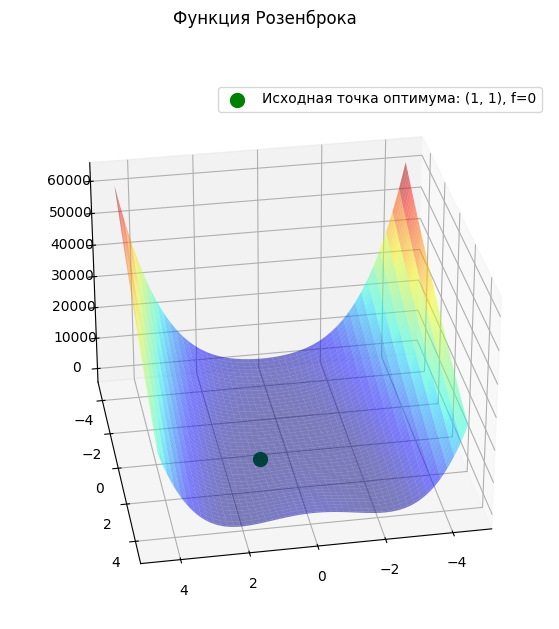

In [489]:
X = np.arange(-4.5, 4.51, 0.01)
Y = np.arange(-4.5, 4.51, 0.01)
rosenbrock_min_point = [1, 1]
show_function(X, Y, rosenbrock, rosenbrock_min_point, 'Функция Розенброка', azim=80)

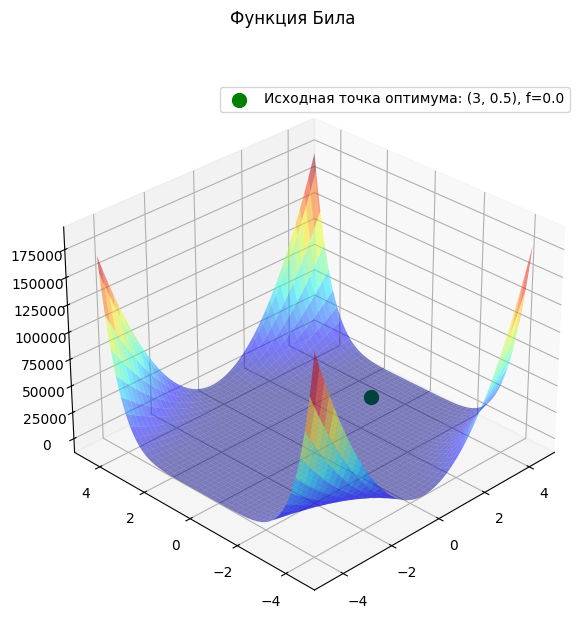

In [490]:
beale_min_point = [3, 0.5]
show_function(X, Y, beale, beale_min_point, 'Функция Била', azim=225)

Реализуем классический градиентный спуск:

In [491]:
def gradient_descent(gradient, start_point, step, iterations, tolerance=1e-6):
    point = np.array(start_point, dtype='float64')
    for _ in range(iterations):
        grad = gradient(*point)
        point = point - [item * step for item in grad]
        if np.linalg.norm(grad) < tolerance:
            break
    return point

Реализуем метод вычисления градиента:

In [492]:
def get_gradient(function, variables=None):
    if variables is None:
        variables = function.free_symbols
    return [sp.diff(function, var) for var in variables]

Пайлайн тестирования алгоритма оптимизации (включает в себя нахождение градиента, вычисление погрешности найденного решения в сравнении с аналитическим и визуализацию):

In [493]:
def calculate_points_and_error(function, gradient, true_optimum, start_points, step=0.001, iterations=10000):
    true_optimum = np.array(true_optimum)
    found_points = []
    errors = []
    for start in start_points:
        found_optimum = function(gradient, start, step, iterations)
        found_points.append(found_optimum)
        error = np.linalg.norm(found_optimum - true_optimum)
        errors.append(error)
    average_error = np.mean(errors)
    return found_points, average_error


def pipe(algorithm, function, true_optimum, start_points, title, azim):
    print(f'Градиент: {(gradient := get_gradient(function))}')
    founded_points, average_error = calculate_points_and_error(algorithm, sp.lambdify((x, y), gradient, "numpy"), true_optimum, start_points)
    print(f'Погрешность: {average_error}')
    show_function(X, Y, function, true_optimum, title, azim=azim, func_optimums=founded_points)

Реализуем моментную модификацию:

In [494]:
def momentum_gradient_descent(gradient, start_point, step, iterations, momentum=0.7, tolerance=1e-6):
    point = np.array(start_point, dtype='float64')
    velocity = np.zeros_like(point)
    for _ in range(iterations):
        grad = gradient(*point)
        velocity = momentum * velocity - [item * step for item in grad]
        point += velocity
        if np.linalg.norm(velocity) < tolerance:
            break
    return point

Реализуем адаптивную модификацию (Adagrad):

In [495]:
def adagrad(gradient, start_point, step, iterations, epsilon=1e-8, tolerance=1e-10):
    point = np.array(start_point, dtype='float64')
    gradient_square_accum = np.zeros_like(point)
    for _ in range(iterations):
        grad = gradient(*point)
        gradient_square_accum += [item **2 for item in grad]
        adjusted_grad = grad / (np.sqrt(gradient_square_accum) + epsilon)
        point -= step * adjusted_grad
        if np.linalg.norm(grad) < tolerance:
            break
    return point

Реализуем метод эволюции темпа обучения (постепенное уменьшение шага):

In [496]:
def momentum_gradient_descent_with_decay(gradient, start_point, step, iterations, momentum=0.7, decay_rate=0.99, tolerance=1e-6):
    point = np.array(start_point, dtype='float64')
    velocity = np.zeros_like(point)
    for t in range(iterations):
        grad = gradient(*point)
        lr_t = step * (decay_rate ** t)
        velocity = momentum * velocity - [item * lr_t for item in grad]
        point += velocity
        if np.linalg.norm(grad) < tolerance:
            break
    return point

### Пайплайн для классического градиентного спуска:

Градиент: [-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]
Погрешность: 0.01586640820433795


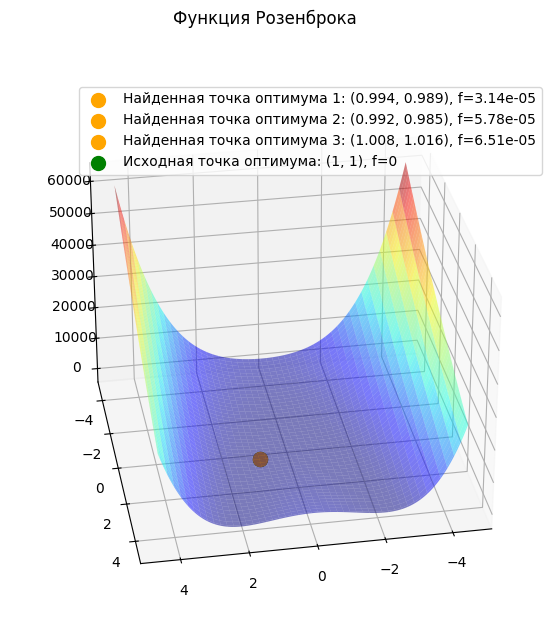

In [497]:
start_points = [[0, 0], [2, 1], [2, 2]]
pipe(gradient_descent, rosenbrock, rosenbrock_min_point, start_points, 'Функция Розенброка', 80)

Градиент: [2.25*(1.33333333333333*y - 1.33333333333333)*(0.666666666666667*x*y - 0.666666666666667*x + 1) + 5.0625*(0.888888888888889*y**2 - 0.888888888888889)*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 6.890625*(0.761904761904762*y**3 - 0.761904761904762)*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1), 15.75*x*y**2*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1) + 9.0*x*y*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 3.0*x*(0.666666666666667*x*y - 0.666666666666667*x + 1)]
Погрешность: 0.01750055450084796


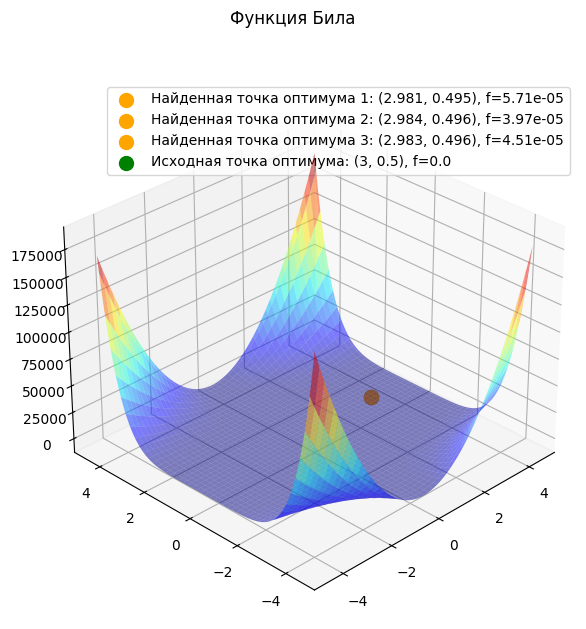

In [498]:
pipe(gradient_descent, beale, beale_min_point, start_points, 'Функция Била', 225)

### Пайплайн для моментной модификации:

Градиент: [-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]
Погрешность: 0.0007467218072038668


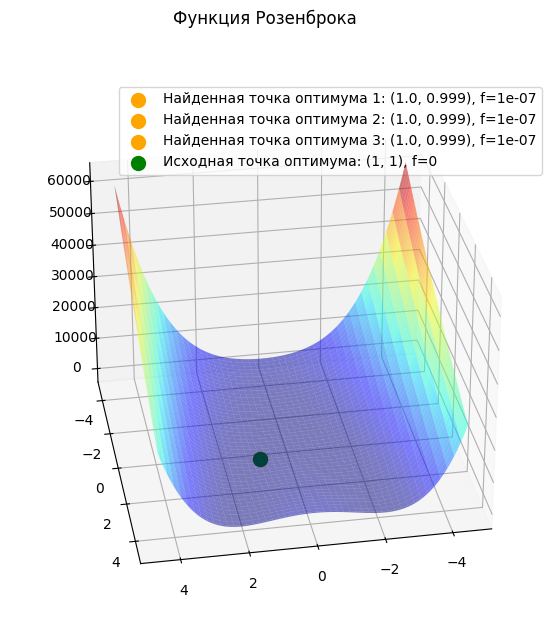

In [499]:
pipe(momentum_gradient_descent, rosenbrock, rosenbrock_min_point, start_points, 'Функция Розенброка', 80)

Градиент: [2.25*(1.33333333333333*y - 1.33333333333333)*(0.666666666666667*x*y - 0.666666666666667*x + 1) + 5.0625*(0.888888888888889*y**2 - 0.888888888888889)*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 6.890625*(0.761904761904762*y**3 - 0.761904761904762)*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1), 15.75*x*y**2*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1) + 9.0*x*y*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 3.0*x*(0.666666666666667*x*y - 0.666666666666667*x + 1)]
Погрешность: 0.0009897109921333603


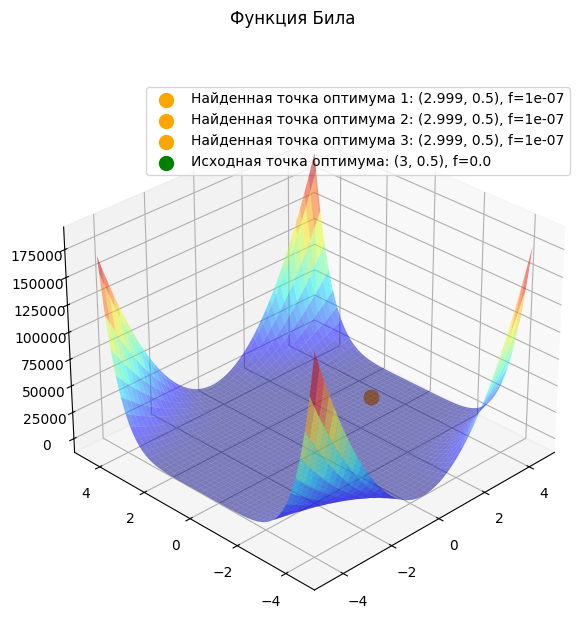

In [500]:
pipe(momentum_gradient_descent, beale, beale_min_point, start_points, 'Функция Била', 225)

### Пайплайн для адаптивной модификации:

Градиент: [-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]
Погрешность: 1.177962180519905


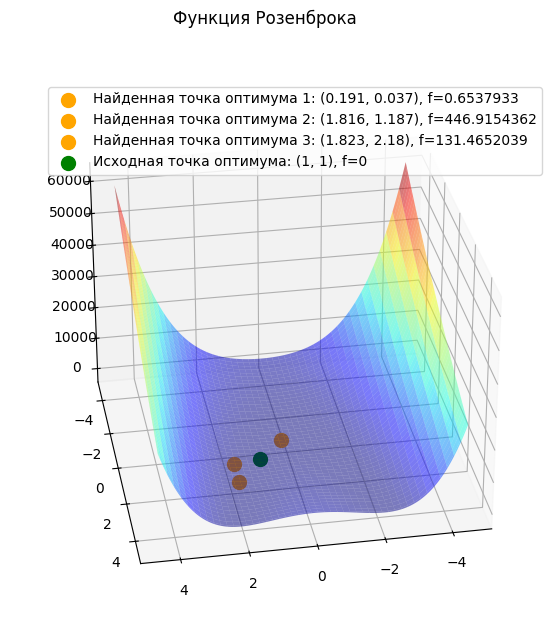

In [501]:
pipe(adagrad, rosenbrock, rosenbrock_min_point, start_points, 'Функция Розенброка', 80)

Градиент: [2.25*(1.33333333333333*y - 1.33333333333333)*(0.666666666666667*x*y - 0.666666666666667*x + 1) + 5.0625*(0.888888888888889*y**2 - 0.888888888888889)*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 6.890625*(0.761904761904762*y**3 - 0.761904761904762)*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1), 15.75*x*y**2*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1) + 9.0*x*y*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 3.0*x*(0.666666666666667*x*y - 0.666666666666667*x + 1)]
Погрешность: 1.8260886861659964


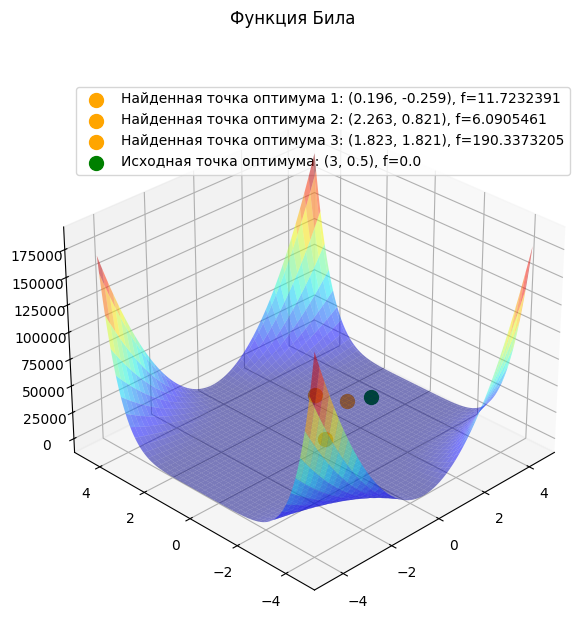

In [502]:
pipe(adagrad, beale, beale_min_point, start_points, 'Функция Била', 225)

### Пайплайн для метода эволюции темпа обучения:

Градиент: [-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]
Погрешность: 0.6577737851468406


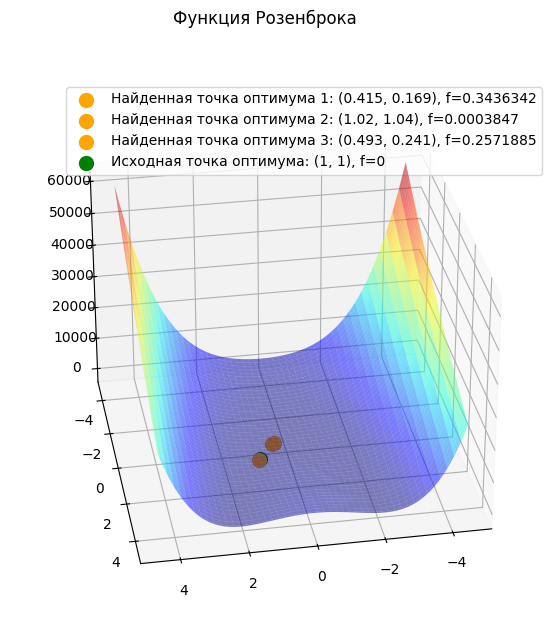

In [503]:
pipe(momentum_gradient_descent_with_decay, rosenbrock, rosenbrock_min_point, start_points, 'Функция Розенброка', 80)

Градиент: [2.25*(1.33333333333333*y - 1.33333333333333)*(0.666666666666667*x*y - 0.666666666666667*x + 1) + 5.0625*(0.888888888888889*y**2 - 0.888888888888889)*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 6.890625*(0.761904761904762*y**3 - 0.761904761904762)*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1), 15.75*x*y**2*(0.380952380952381*x*y**3 - 0.380952380952381*x + 1) + 9.0*x*y*(0.444444444444444*x*y**2 - 0.444444444444444*x + 1) + 3.0*x*(0.666666666666667*x*y - 0.666666666666667*x + 1)]
Погрешность: 1.135198170070092


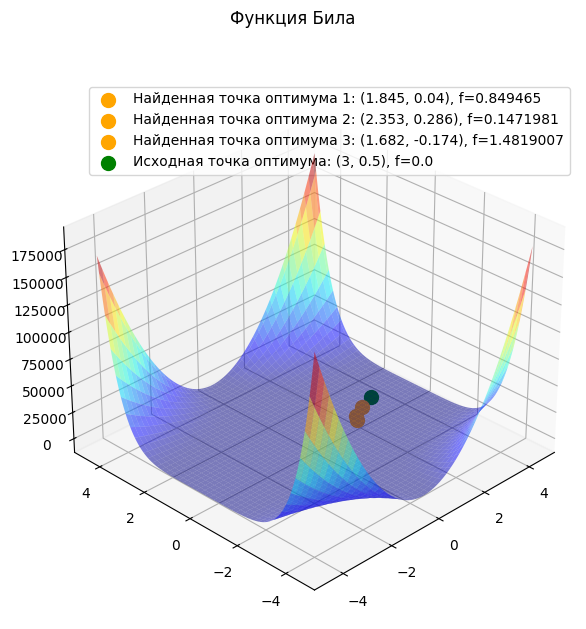

In [504]:
pipe(momentum_gradient_descent_with_decay, beale, beale_min_point, start_points, 'Функция Била', 225)